**Chapter 14 – Deep Computer Vision Using Convolutional Neural Networks**

_This notebook contains all the sample code in chapter 14._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [11]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses

assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


A couple utility functions to plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

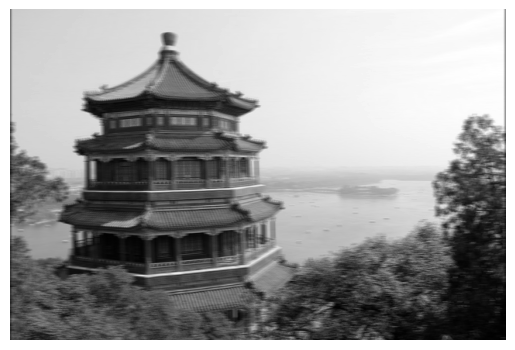

In [5]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

# What is a Convolution?

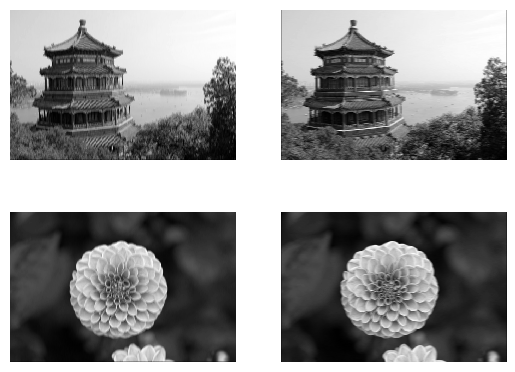

In [ ]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [ ]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


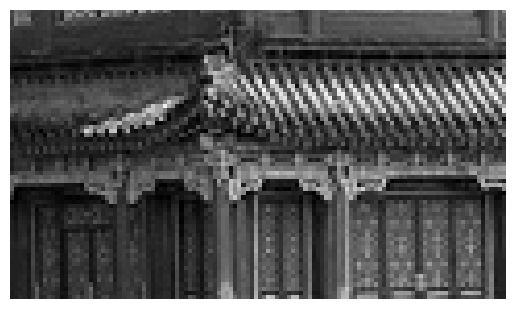

Saving figure china_vertical


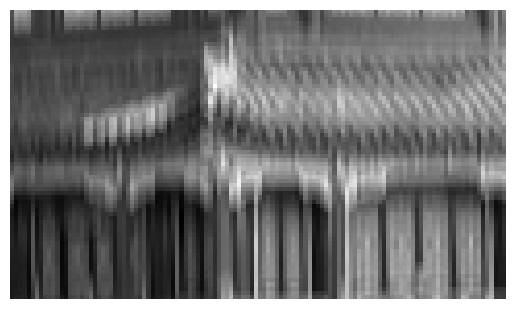

Saving figure china_horizontal


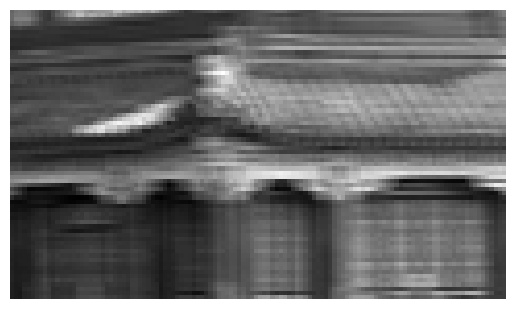

In [ ]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

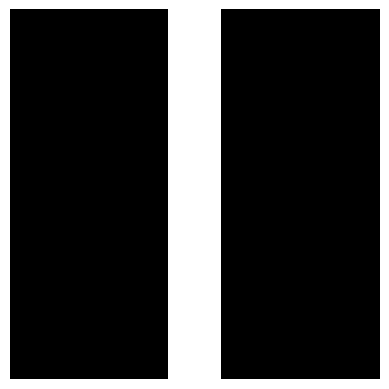

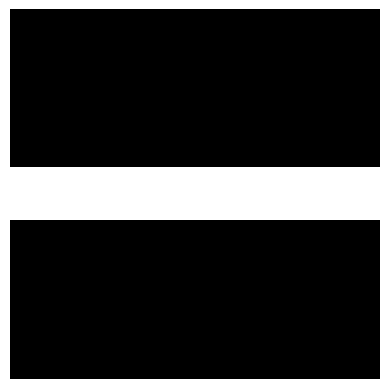

In [ ]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## Convolutional Layer

Using `keras.layers.Conv2D()`:

In [ ]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

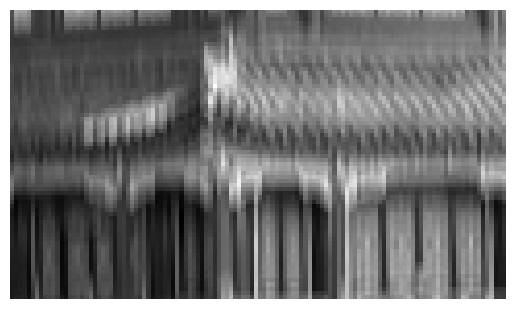

In [ ]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

## VALID vs SAME padding

In [ ]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [ ]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [ ]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using `"SAME"` padding is equivalent to padding manually using `manual_same_padding()` then using `"VALID"` padding (confusingly, `"VALID"` padding means no padding at all):

In [ ]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

# Pooling layer

## Max pooling

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [ ]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


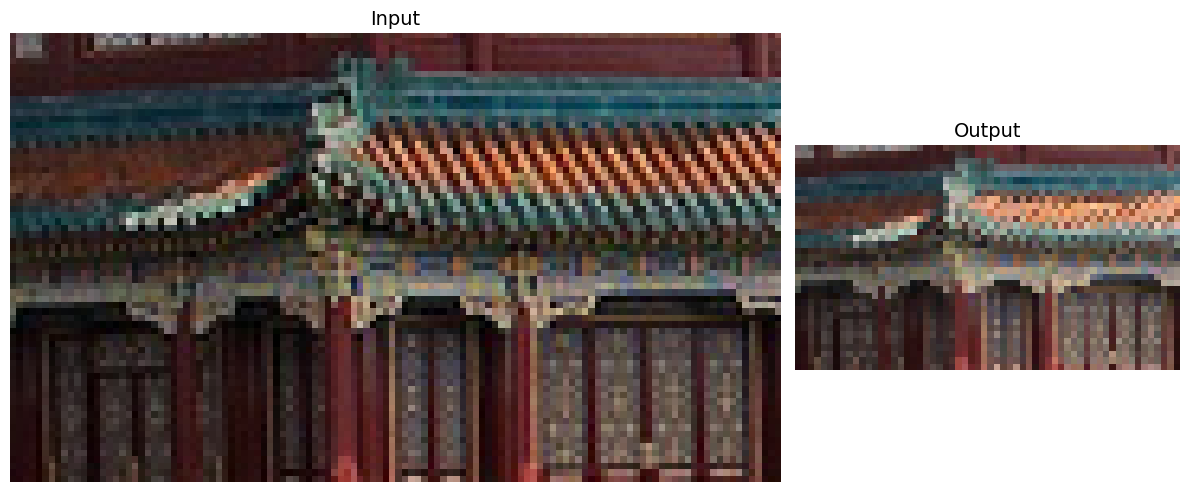

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

## Depth-wise pooling

In [ ]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [ ]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

Or just use a `Lambda` layer:

In [ ]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

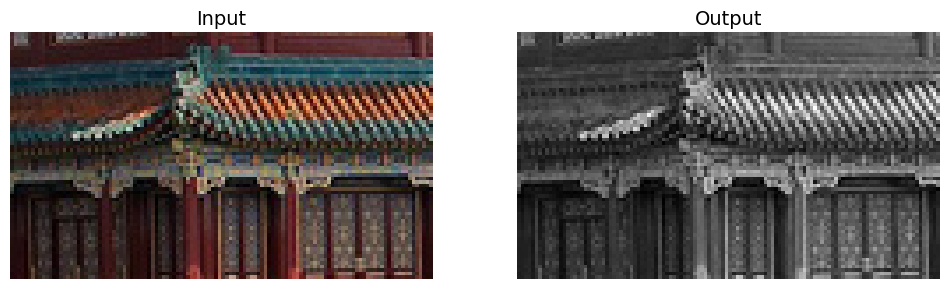

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

## Average pooling

In [ ]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [ ]:
output_avg = avg_pool(cropped_images)

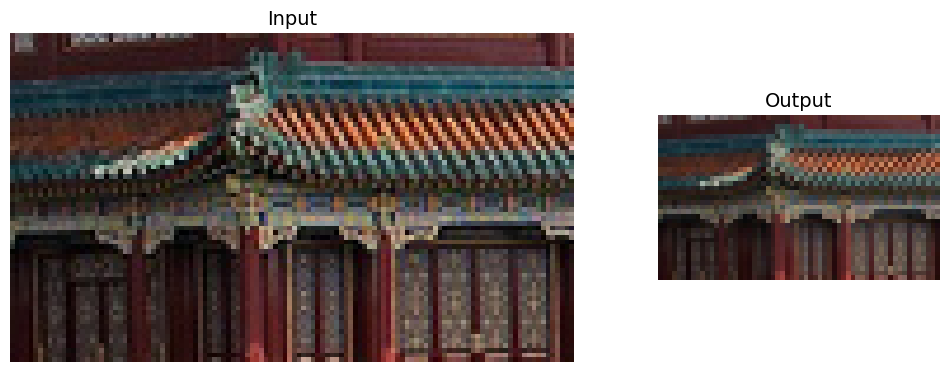

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Global Average Pooling

In [ ]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

In [ ]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

# Tackling Fashion MNIST With a CNN

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4422102/4422102 [==============================] - 0s 0us/step


##LeNet

In [ ]:
lenet = models.Sequential()
lenet.add(layers.Conv2D(6, 5, activation='tanh', padding='same',  input_shape=[28, 28, 1]))
lenet.add(layers.AveragePooling2D(2))
lenet.add(layers.Activation('sigmoid'))
lenet.add(layers.Conv2D(16, 5, activation='tanh'))
lenet.add(layers.AveragePooling2D(2))
lenet.add(layers.Activation('sigmoid'))
lenet.add(layers.Conv2D(120, 5, activation='tanh'))
lenet.add(layers.Flatten())
lenet.add(layers.Dense(84, activation='tanh'))
lenet.add(layers.Dense(10, activation='softmax'))
lenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_1 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 activation (Activation)     (None, 14, 14, 6)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_2 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 activation_1 (Activation)   (None, 5, 5, 16)          0

In [ ]:
lenet.compile(optimizer='sgd', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = lenet.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


Epoch 1/10
1719/1719 [==============================] - 13s 5ms/step - loss: 1.8358 - accuracy: 0.3552 - val_loss: 1.0257 - val_accuracy: 0.6416
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.8645 - accuracy: 0.6871 - val_loss: 0.7492 - val_accuracy: 0.7256
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.7282 - accuracy: 0.7242 - val_loss: 0.6704 - val_accuracy: 0.7516
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6748 - accuracy: 0.7419 - val_loss: 0.6212 - val_accuracy: 0.7716
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6333 - accuracy: 0.7602 - val_loss: 0.5887 - val_accuracy: 0.7764
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6005 - accuracy: 0.7758 - val_loss: 0.5879 - val_accuracy: 0.7664
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5765 - accuracy: 0.7874 - val_loss: 0.5418 - val_accuracy

In [ ]:
score = lenet.evaluate(X_test, y_test)
print(score)
X_new = X_test[:10] # pretend we have new images
y_pred = lenet.predict(X_new)
y_pred

313/313 [==============================] - 1s 3ms/step - loss: 0.5373 - accuracy: 0.8033
[0.5373387932777405, 0.8033000230789185]
1/1 [==============================] - 0s 232ms/step


array([[1.59336173e-06, 1.44837111e-06, 1.39151271e-05, 2.55232317e-06,
        4.53085013e-05, 1.46866336e-01, 6.18337981e-06, 3.29416305e-01,
        2.28640903e-03, 5.21359921e-01],
       [3.69858230e-03, 3.08074843e-04, 8.35791171e-01, 1.30506353e-02,
        3.24906409e-02, 1.37837429e-04, 1.13207325e-01, 2.44932590e-08,
        1.31179462e-03, 3.88996159e-06],
       [6.99069642e-04, 9.93913352e-01, 5.39585635e-05, 1.67959300e-03,
        3.27613438e-03, 2.47748926e-06, 2.69719778e-04, 1.01010730e-04,
        4.53260691e-06, 2.18905228e-07],
       [1.13077425e-04, 9.91602838e-01, 2.29860889e-05, 7.26220710e-03,
        8.40697205e-04, 3.32824015e-06, 4.54731053e-05, 1.07985703e-04,
        2.27867304e-07, 1.23461098e-06],
       [2.23403461e-02, 8.19175271e-04, 1.86075211e-01, 1.85258985e-02,
        3.22950669e-02, 3.59435682e-04, 7.35838950e-01, 7.85027225e-08,
        3.73906363e-03, 6.83411417e-06],
       [3.00277537e-03, 9.73209202e-01, 3.67871224e-04, 3.96090094e-03,
   

New model

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 256)        

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)


Epoch 1/10
1719/1719 [==============================] - 21s 9ms/step - loss: 0.7108 - accuracy: 0.7515 - val_loss: 0.4431 - val_accuracy: 0.8520
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4380 - accuracy: 0.8527 - val_loss: 0.3540 - val_accuracy: 0.8764
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3790 - accuracy: 0.8735 - val_loss: 0.3146 - val_accuracy: 0.8860
Epoch 4/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3405 - accuracy: 0.8840 - val_loss: 0.2985 - val_accuracy: 0.8944
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3147 - accuracy: 0.8942 - val_loss: 0.2970 - val_accuracy: 0.8930
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3028 - accuracy: 0.8968 - val_loss: 0.2884 - val_accuracy: 0.8996
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2899 - accuracy: 0.9017 - val_loss: 0.2720 - val_ac

In [ ]:
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)
y_pred

1/1 [==============================] - 0s 224ms/step


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0060707e-18, 0.0000000e+00, 3.1131049e-14,
        0.0000000e+00, 1.0000000e+00],
       [7.9772598e-11, 8.5567257e-28, 9.9976689e-01, 2.6088013e-18,
        3.1439217e-06, 1.9025834e-34, 2.2995763e-04, 5.1208069e-37,
        2.2073313e-18, 5.0507330e-37],
       [1.4870618e-20, 1.0000000e+00, 1.2843105e-21, 2.1624784e-16,
        8.9028221e-20, 0.0000000e+00, 3.0839408e-17, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.8560625e-31, 1.0000000e+00, 1.3797446e-32, 4.0941531e-25,
        4.3671435e-31, 0.0000000e+00, 3.7323629e-26, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [4.6097799e-03, 5.7841143e-10, 7.4714550e-04, 9.7248492e-05,
        3.4009970e-03, 8.7066536e-13, 9.9114460e-01, 8.4902019e-16,
        1.6591322e-07, 4.8495071e-16],
       [4.0653698e-21, 1.0000000e+00, 1.4811660e-23, 1.8305441e-17,
        4.2045246e-22, 0.0000000e+00, 8.9085005e-19, 0.00

## ResNet-34

In [ ]:
from functools import partial

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

Original ResNet Configuration

In [ ]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 activation_2 (Activation)   (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 residual_unit (ResidualUni  (None, 56, 56, 64)        74240     
 t)                                                              
                                                      

Updated ResNet for FashionMinist

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(DefaultConv2D(32, kernel_size=1, strides=1,
                        input_shape=[28, 28, 1]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
#model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 32
#for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
for filters in [32] * 3 + [48] * 4  + [54] * 4 + [60] * 3+ [64] * 3+ [128] * 3 :
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
#model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        32        
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 residual_unit (ResidualUni  (None, 28, 28, 32)        18688     
 t)                                                              
                                                                 
 residual_unit_1 (ResidualU  (None, 28, 28, 32)        18688     
 nit)                                                            
                                                        

In [ ]:
from keras.preprocessing.image import ImageDataGenerator # This will help to make data augmentation and batches of images


datagen = ImageDataGenerator(rotation_range=10, # Rotating randomly the images up to 25°
                             width_shift_range=0.1, # Moving the images from left to right
                             height_shift_range=0.1, # Then from top to bottom
                             shear_range=0.10,
                             zoom_range=0.05, # Zooming randomly up to 20%
                             zca_whitening=False,
                             horizontal_flip=True,
                             vertical_flip=False,
                            fill_mode = 'nearest')

datagen.fit(X_train) # Very important to fit the Generator on the data



In [ ]:
EPOCHS = 20 # Number of time the model will see the data
BATCH_SIZE = 32 # Number of images per batch
STEPS_PER_EPOCH = X_train.shape[0] // BATCH_SIZE # Since we are batching, we need to specify when the model should consider that one epoch has been processed.
# A proper way to fix this parameter is to have a number of step equal to the number of data

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=BATCH_SIZE),
                              epochs = EPOCHS,
                              validation_data = (X_valid,y_valid),
                              verbose = 2,
                              steps_per_epoch=STEPS_PER_EPOCH)

score = model.evaluate(X_test, y_test)

Epoch 1/20


<ipython-input-9-eba306bc88ae>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=BATCH_SIZE),


1718/1718 - 116s - loss: 0.3465 - accuracy: 0.8833 - val_loss: 0.2474 - val_accuracy: 0.9072 - 116s/epoch - 68ms/step
Epoch 2/20
1718/1718 - 80s - loss: 0.3309 - accuracy: 0.8850 - val_loss: 0.2817 - val_accuracy: 0.8956 - 80s/epoch - 47ms/step
Epoch 3/20
1718/1718 - 82s - loss: 0.2986 - accuracy: 0.8942 - val_loss: 0.3218 - val_accuracy: 0.8802 - 82s/epoch - 48ms/step
Epoch 4/20
1718/1718 - 83s - loss: 0.2935 - accuracy: 0.8962 - val_loss: 0.2587 - val_accuracy: 0.9048 - 83s/epoch - 49ms/step
Epoch 5/20
1718/1718 - 81s - loss: 0.2825 - accuracy: 0.9005 - val_loss: 0.2417 - val_accuracy: 0.9098 - 81s/epoch - 47ms/step
Epoch 6/20
1718/1718 - 80s - loss: 0.2776 - accuracy: 0.9027 - val_loss: 0.2236 - val_accuracy: 0.9192 - 80s/epoch - 47ms/step
Epoch 7/20
1718/1718 - 81s - loss: 0.2711 - accuracy: 0.9046 - val_loss: 0.2399 - val_accuracy: 0.9172 - 81s/epoch - 47ms/step
Epoch 8/20
1718/1718 - 81s - loss: 0.2562 - accuracy: 0.9099 - val_loss: 0.2314 - val_accuracy: 0.9162 - 81s/epoch - 47m

# Using a Pretrained Model

In [3]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 5s 0us/step


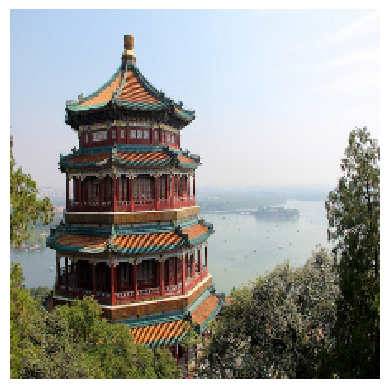

In [6]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

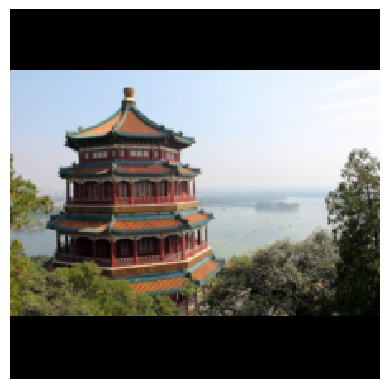

In [7]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

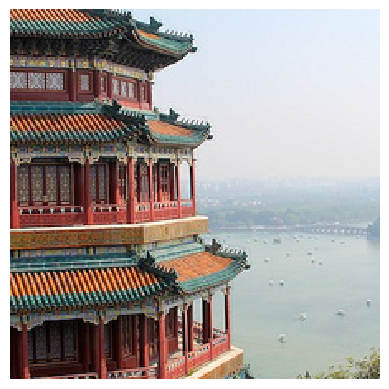

In [8]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

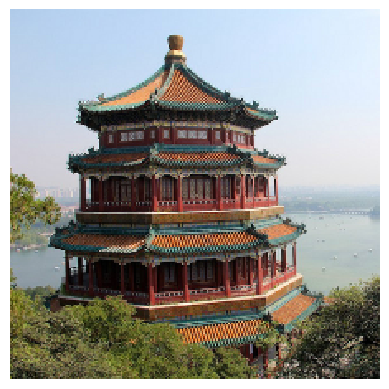

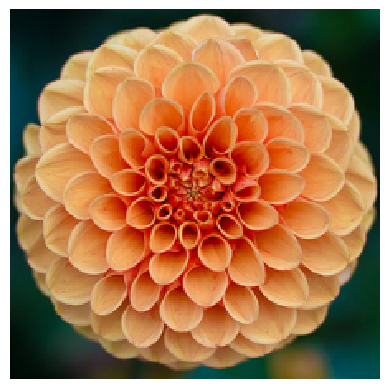

In [9]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [10]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

1/1 [==============================] - 2s 2s/step


In [11]:
Y_proba.shape

(2, 1000)

In [12]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

35363/35363 [==============================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.08%
  n03781244 - monastery    11.69%

Image #1
  n04522168 - vase         53.97%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.96%



# Pretrained Models for Transfer Learning

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [3]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [4]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [5]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [6]:
n_classes = info.features["label"].num_classes
n_classes

5

In [7]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

**Warning:** TFDS's split API has evolved since the book was published. The [new split API](https://www.tensorflow.org/datasets/splits) (called S3) is much simpler to use:

In [8]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

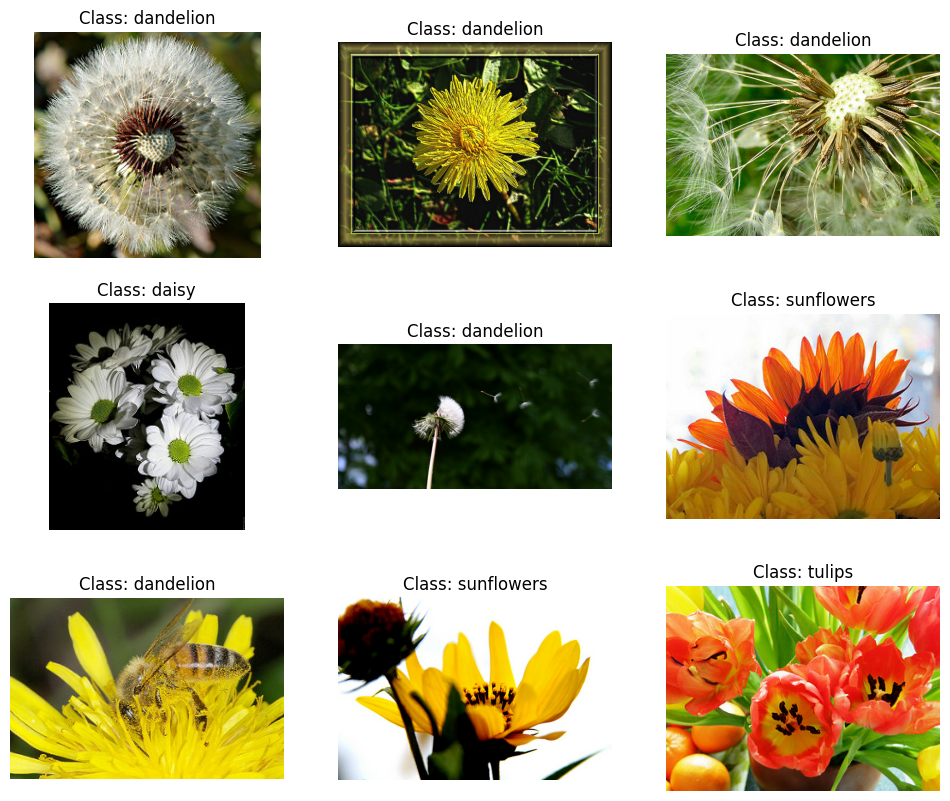

In [21]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Basic preprocessing:

In [9]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Slightly fancier preprocessing (but you could add much more data augmentation):

In [12]:
from functools import partial

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [21]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

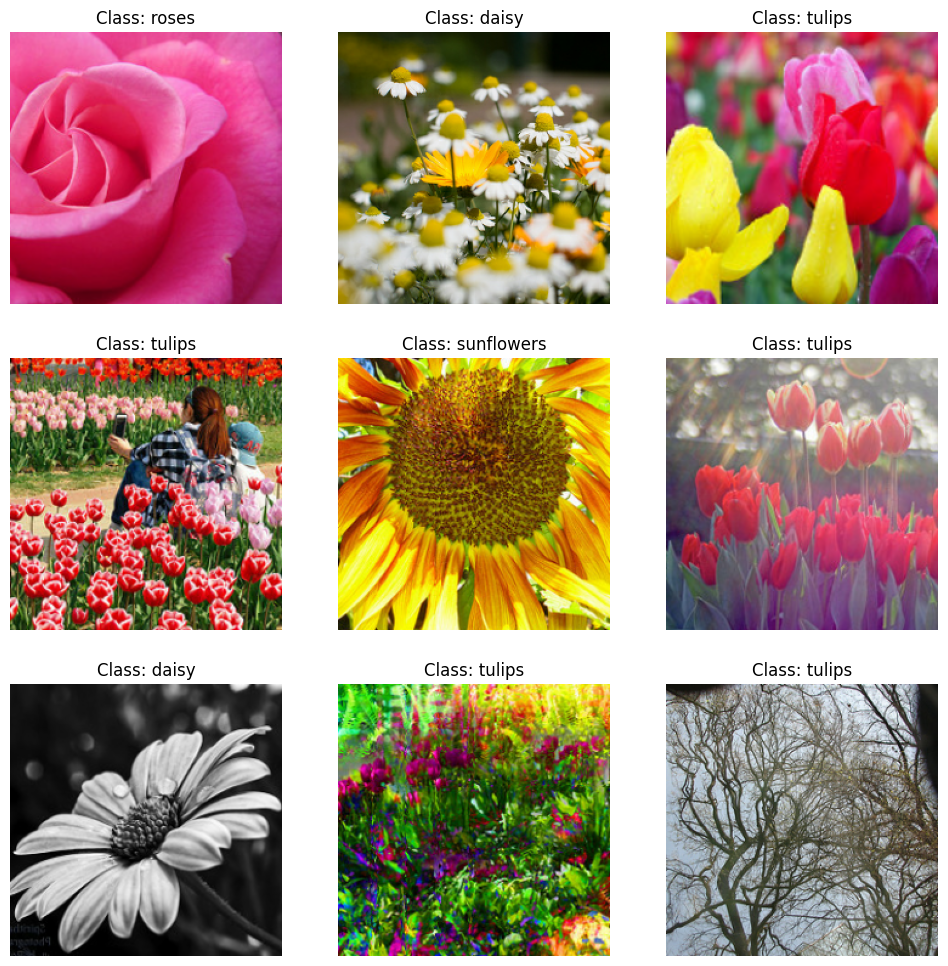

In [20]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

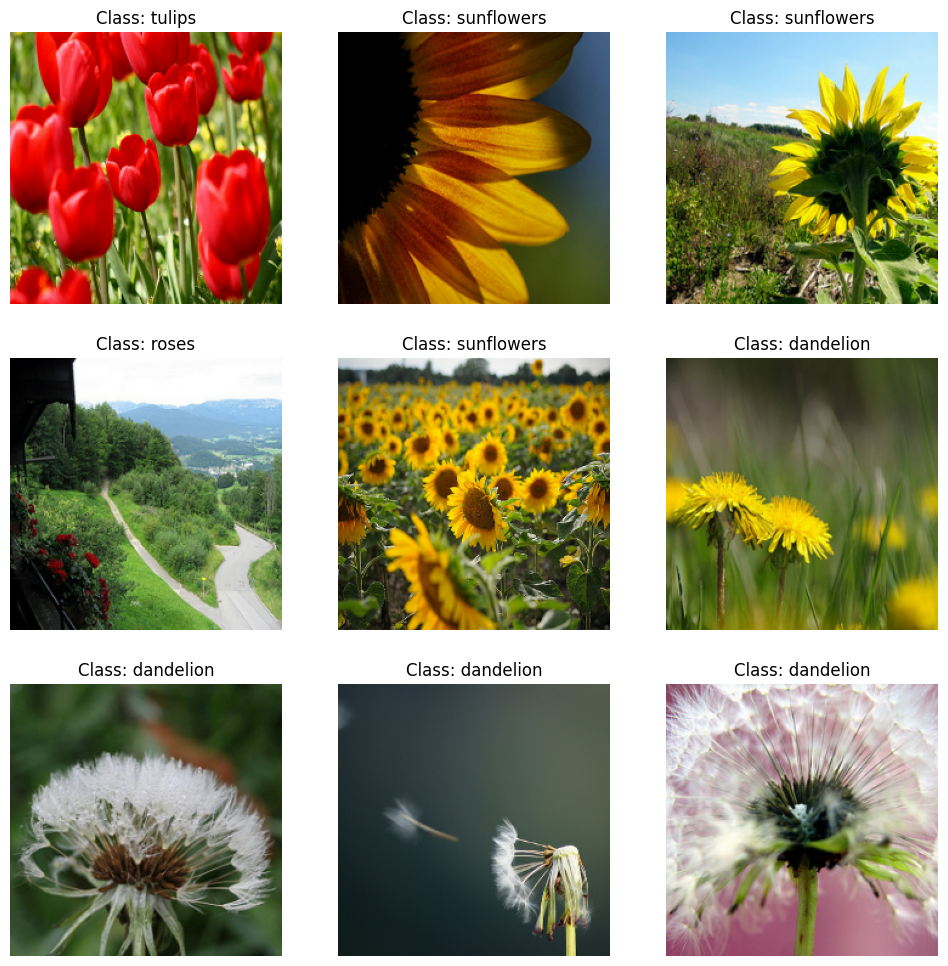

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [35]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 5s 0us/step


In [36]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [37]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, weight_decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 21s 169ms/step - loss: 1.3932 - accuracy: 0.7827 - val_loss: 1.1227 - val_accuracy: 0.8401
Epoch 2/5
86/86 [==============================] - 13s 155ms/step - loss: 0.7913 - accuracy: 0.8797 - val_loss: 1.3247 - val_accuracy: 0.8346
Epoch 3/5
86/86 [==============================] - 13s 157ms/step - loss: 0.6808 - accuracy: 0.8888 - val_loss: 1.3524 - val_accuracy: 0.8254
Epoch 4/5
86/86 [==============================] - 13s 156ms/step - loss: 0.5165 - accuracy: 0.9052 - val_loss: 0.9906 - val_accuracy: 0.8346
Epoch 5/5
86/86 [==============================] - 13s 157ms/step - loss: 0.6006 - accuracy: 0.8903 - val_loss: 2.3584 - val_accuracy: 0.7812


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, weight_decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 64s 496ms/step - loss: 0.3798 - accuracy: 0.8841 - val_loss: 0.6648 - val_accuracy: 0.8033
Epoch 2/40
86/86 [==============================] - 43s 497ms/step - loss: 0.1622 - accuracy: 0.9502 - val_loss: 0.4073 - val_accuracy: 0.8750
Epoch 3/40
86/86 [==============================] - 43s 496ms/step - loss: 0.0801 - accuracy: 0.9757 - val_loss: 0.2785 - val_accuracy: 0.9191
Epoch 4/40
86/86 [==============================] - 43s 498ms/step - loss: 0.0484 - accuracy: 0.9829 - val_loss: 0.3115 - val_accuracy: 0.9136
Epoch 5/40
86/86 [==============================] - 43s 498ms/step - loss: 0.0483 - accuracy: 0.9815 - val_loss: 0.3283 - val_accuracy: 0.9007
Epoch 6/40
86/86 [==============================] - 43s 495ms/step - loss: 0.0318 - accuracy: 0.9884 - val_loss: 0.3243 - val_accuracy: 0.9099
Epoch 7/40
86/86 [==============================] - 43s 498ms/step - loss: 0.0355 - accuracy: 0.9887 - val_loss: 0.3778 - val_accuracy: 0.9136

# Classification and Localization

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# extra code – fits the model using random target bounding boxes (in real life
#              you would need to create proper targets instead)

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)


In [ ]:
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 [==============================] - 16s 454ms/step - loss: 1.2291 - dense_11_loss: 1.4762 - dense_12_loss: 0.2406 - dense_11_accuracy: 0.4125 - dense_12_accuracy: 0.2688
Epoch 2/2
10/10 [==============================] - 5s 449ms/step - loss: 0.9149 - dense_11_loss: 1.0963 - dense_12_loss: 0.1896 - dense_11_accuracy: 0.6187 - dense_12_accuracy: 0.2531


### Mean Average Precision (mAP)

In [ ]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

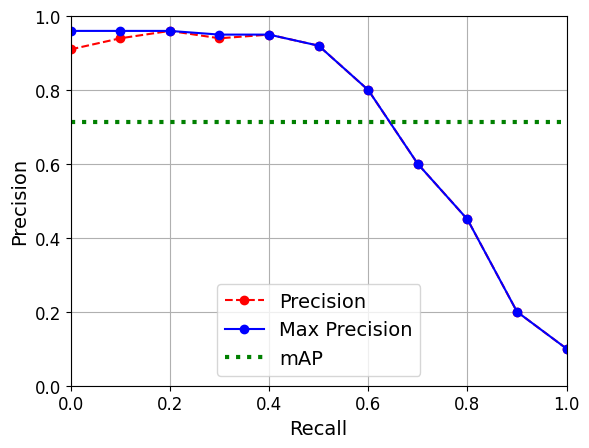

In [ ]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

Transpose convolutions:

In [ ]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

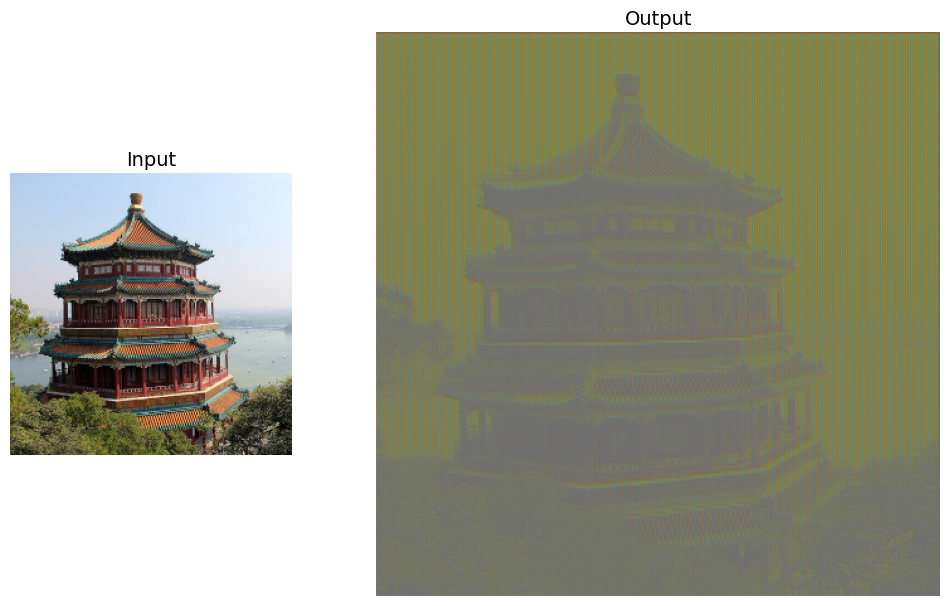

In [ ]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [ ]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [ ]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

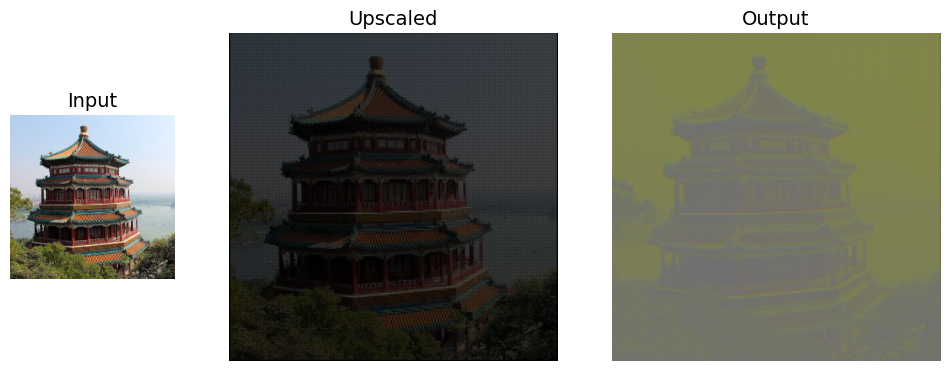

In [ ]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()

In [ ]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True

# Exercises

## 1. to 8.

See appendix A.

## 9. High Accuracy CNN for MNIST
_Exercise: Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST._

The following model uses 2 convolutional layers, followed by 1 pooling layer, then dropout 25%, then a dense layer, another dropout layer but with 50% dropout, and finally the output layer. It reaches about 99.2% accuracy on the test set. This places this model roughly in the top 20% in the [MNIST Kaggle competition](https://www.kaggle.com/c/digit-recognizer/) (if we ignore the models with an accuracy greater than 99.79% which were most likely trained on the test set, as explained by Chris Deotte in [this post](https://www.kaggle.com/c/digit-recognizer/discussion/61480)). Can you do better? To reach 99.5 to 99.7% accuracy on the test set, you need to add image augmentation, batch norm, use a learning schedule such as 1-cycle, and possibly create an ensemble.

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(420)
np.random.seed(420)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])


Epoch 1/10
1719/1719 [==============================] - 16s 6ms/step - loss: 0.4573 - accuracy: 0.8400 - val_loss: 0.2685 - val_accuracy: 0.8972
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2980 - accuracy: 0.8939 - val_loss: 0.2358 - val_accuracy: 0.9118
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2549 - accuracy: 0.9069 - val_loss: 0.2186 - val_accuracy: 0.9166
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2251 - accuracy: 0.9166 - val_loss: 0.2099 - val_accuracy: 0.9222
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.1996 - accuracy: 0.9270 - val_loss: 0.2183 - val_accuracy: 0.9170
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.1820 - accuracy: 0.9329 - val_loss: 0.2085 - val_accuracy: 0.9254
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.1689 - accuracy: 0.9377 - val_loss: 0.2029 - val_ac

[0.23596034944057465, 0.9283999800682068]

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 14s 6ms/step - loss: 0.0555 - accuracy: 0.9798 - val_loss: 0.3056 - val_accuracy: 0.9296
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0486 - accuracy: 0.9819 - val_loss: 0.3798 - val_accuracy: 0.9284
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0508 - accuracy: 0.9816 - val_loss: 0.4154 - val_accuracy: 0.9278
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0460 - accuracy: 0.9830 - val_loss: 0.4172 - val_accuracy: 0.9256
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0480 - accuracy: 0.9826 - val_loss: 0.3898 - val_accuracy: 0.9250
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0475 - accuracy: 0.9829 - val_loss: 0.3929 - val_accuracy: 0.9284
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0456 - accuracy: 0.9834 - val_loss: 0.3471 - val_ac

[0.5051218867301941, 0.9289000034332275]

## 10.  Use transfer learning for large image classification

_Exercise: Use transfer learning for large image classification, going through these steps:_

* _Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets)._
* _Split it into a training set, a validation set, and a test set._
* _Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation._
* _Fine-tune a pretrained model on this dataset._

See the Flowers example above.

## 11.
_Exercise: Go through TensorFlow's [Style Transfer tutorial](https://homl.info/styletuto). It is a fun way to generate art using Deep Learning._


Simply open the Colab and follow its instructions.